In [1]:
import croissant as cro
import healpy
import matplotlib.pyplot as plt
import numpy as np

In spherical coordinates, where $\theta$ is the polar angle, the power of a dipole antenna is given by:
$$P(\theta, \nu) \propto (L\nu)^2 \cos^2{\theta} $$

In [2]:
# 1 deg spacing, must be radians
theta = np.linspace(0, np.pi, num=181)
theta.shape = (1, -1, 1)
phi = np.linspace(0, 2 * np.pi, num=360, endpoint=False)
phi.shape = (1, 1, -1)
# 1 MHz resolution frequency
freq = np.linspace(1, 50, num=50)
freq.shape = (-1, 1, 1)
# dipole beam
#power = freq**2 * np.ones((freq.size, theta.size, phi.size))
power = freq**2 * np.cos(theta)**2
power = np.repeat(power, phi.size, axis=-1)

In [3]:
beam = cro.beam.Beam(power, theta, phi, frequencies=freq)

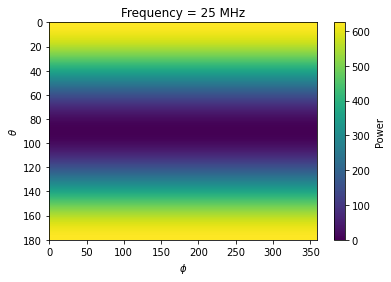

In [4]:
plot_freq = 25  # MHz
freq_ix = np.argmin(np.abs(beam.frequencies-plot_freq))
ex = [beam.phi.min(), beam.phi.max(), beam.theta.max(), beam.theta.min()]
ex_deg = [np.rad2deg(bd) for bd in ex]
plt.figure()
plt.imshow(beam.data[freq_ix], aspect="auto", extent=ex_deg)
plt.colorbar(label="Power")
plt.title(f"Frequency = {beam.frequencies[freq_ix]:.0f} MHz")
plt.xlabel("$\\phi$")
plt.ylabel("$\\theta$")
plt.show()

Vizualize the beam with a healpix map

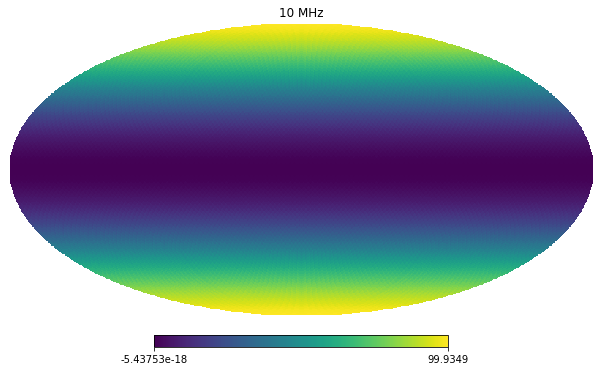

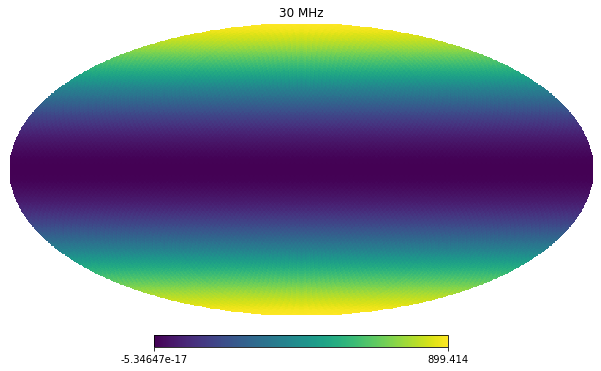

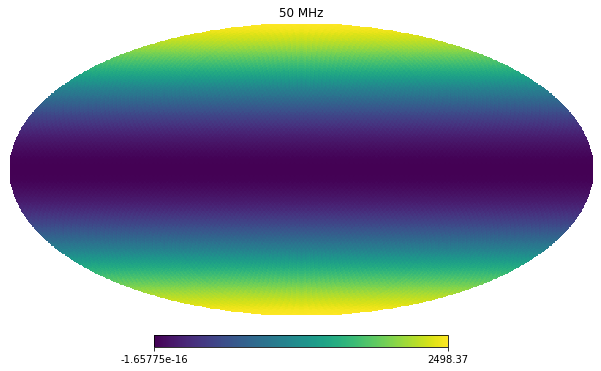

In [5]:
hp_beam = cro.healpix.grid2healpix(beam.data, 32, theta=beam.theta, phi=beam.phi)
for i in [9, 29, 49]:
    healpy.mollview(hp_beam[i], cbar=True, title=f"{beam.frequencies[i]:.0f} MHz")

We use the Global Sky Model (Zheng et al 2016) at 25 MHz as the sky model and extrpolate it by a power law to other frequencies. It has a built-in interface in the sky module of croissant.

In [6]:
sky = cro.sky.Sky.gsm(25)
sky.power_law_map(beam.frequencies, spectral_index=-2.5)



# nside = 64
# npix = healpy.nside2npix(nside)
# ref_map = np.ones(npix) * 180
# ref_freq = 180
# sky = cro.sky.Sky()
# sky.power_law_map(beam.frequencies, ref_map=ref_map, ref_freq=ref_freq)

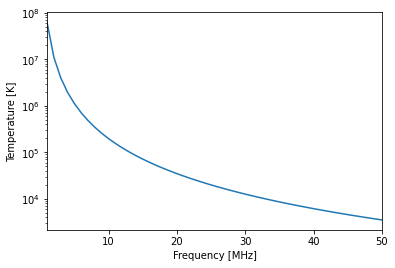

In [7]:
# the sky model is indeed a perfect power law
plt.figure()
plt.plot(sky.frequencies, sky.data[:,0])
plt.xlabel("Frequency [MHz]")
plt.ylabel("Temperature [K]")
plt.xlim(sky.frequencies.min(), sky.frequencies.max())
plt.yscale("log")
plt.show()

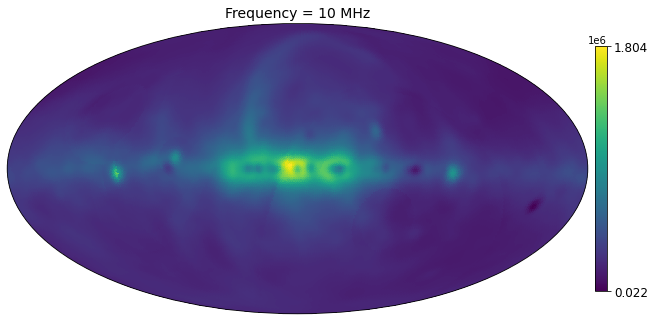

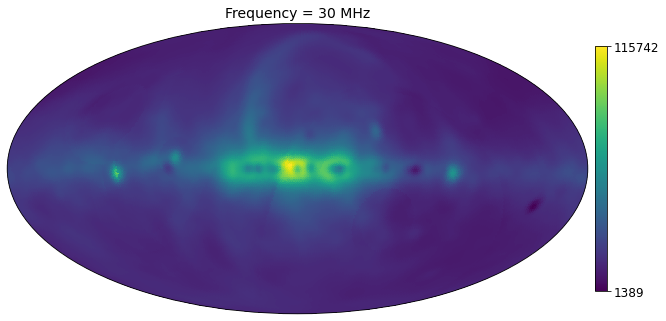

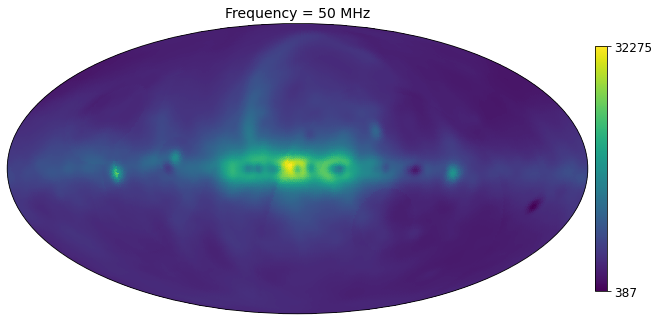

In [8]:
for freq in sky.frequencies[9::20]:
    sky.plot(frequency=freq, cbar=True, cb_orientation="vertical", projection_type="mollweide")

Run the simulator!

In [9]:
# let's do a full day
lmax = 128
dpss_nterms = 15
#loc = (0., 0., 0.)
loc = (37.8, 122.3, 0)
sim = cro.simulator.Simulator(
    beam, sky, obs_loc=loc, t_start="2022-06-02T15:43:43", N_times=300, t_end="2022-06-03T15:43:43",
    lmax=lmax, dpss_nterms=dpss_nterms
)
sim.run()

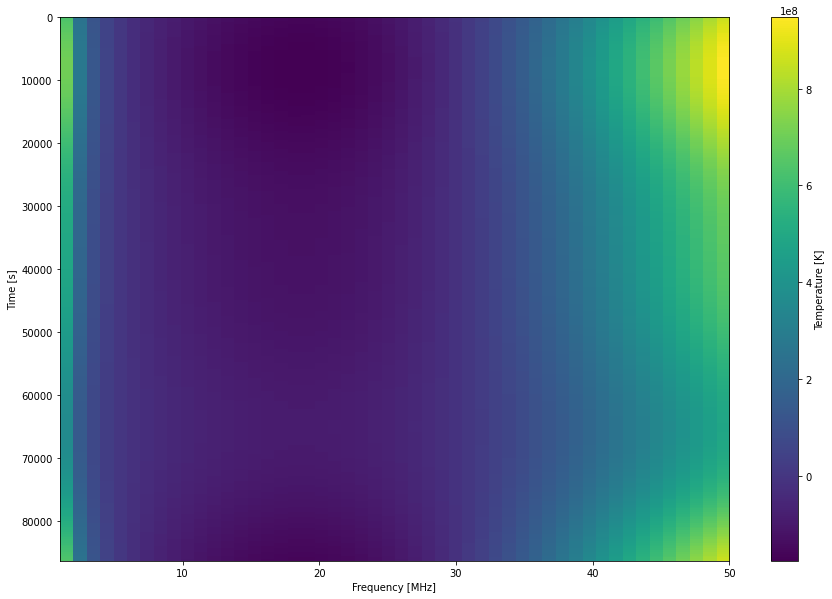

In [10]:
sim.plot(figsize=(15,10), power=1)

In [11]:
print(sim.waterfall.min())

-11335518.242238376


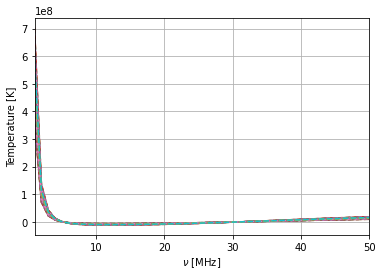

In [12]:
plt.figure()
plt.plot(sim.frequencies, sim.waterfall[::10].T, ls="--")
plt.xlim(sim.frequencies.min(), sim.frequencies.max())
plt.xlabel("$\\nu$ [MHz]")
plt.ylabel("Temperature [K]")
plt.grid()
plt.show()

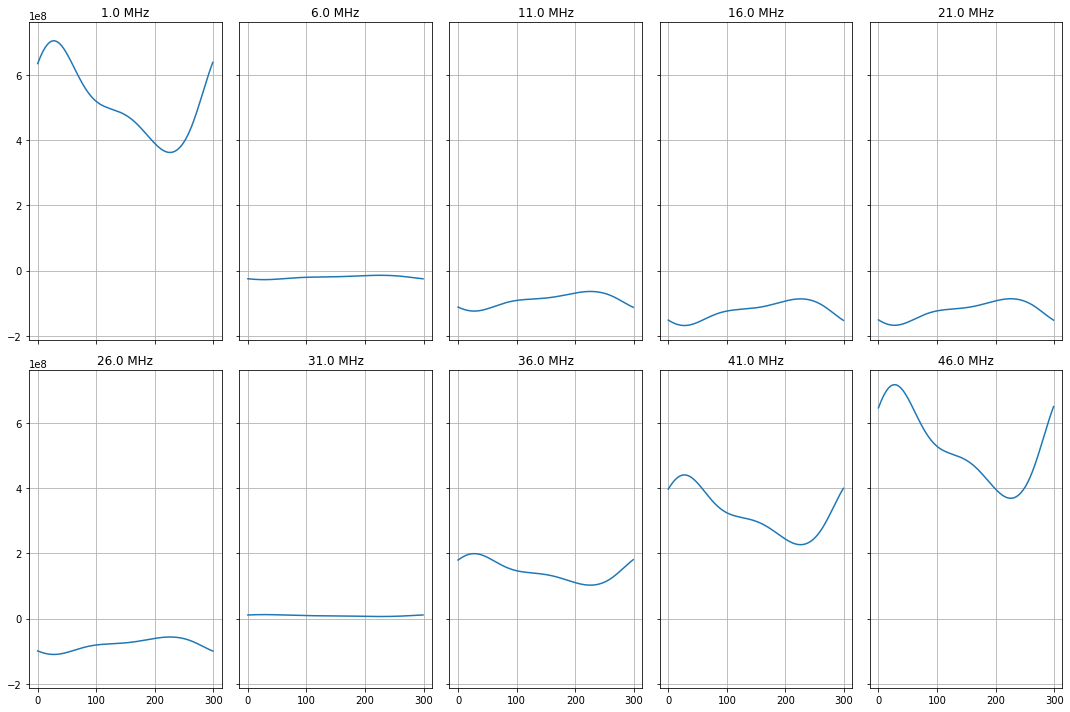

In [13]:
# Temp vs time
fig, axs = plt.subplots(figsize=(15,10), nrows=2, ncols=5, sharex=True, sharey=True)
for i, f in enumerate(sim.frequencies[::5]):
    ax = axs.ravel()[i]
    fidx = np.argwhere(sim.frequencies == f)[0, 0]
    ax.plot(sim.waterfall[:, fidx] * f**1)
    ax.set_title(f"{f} MHz")
    ax.grid()
plt.tight_layout()
plt.show()

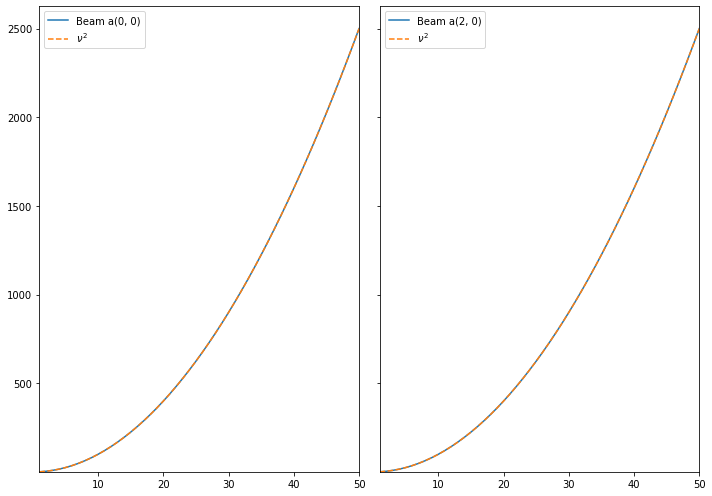

In [14]:
ells = [0, 2]
emms = [0, 0]
fig, axs = plt.subplots(figsize=(10,7), ncols=2, sharex=True, sharey=True)
for i in range(2):
    ell, emm = ells[i], emms[i]
    ix = healpy.Alm.getidx(sim.lmax, ell, emm)
    plt.sca(axs[i])
    plt.plot(sim.frequencies, sim.beam.alm[:, ix].real / sim.beam.alm[0, ix].real, label=f"Beam a{ell,emm}")
    plt.plot(sim.frequencies, sim.frequencies**2, ls="--", label="$\\nu^2$")
    plt.legend()
    plt.ylim(1)
    plt.xlim(sim.frequencies.min(), sim.frequencies.max())
plt.tight_layout()
plt.show()

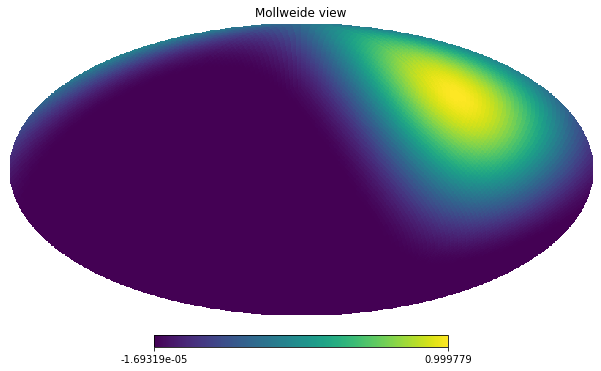

In [15]:
m = healpy.alm2map(sim.beam.alm[0], nside=32)
healpy.mollview(m)

In [16]:
np.allclose(sim.beam.alm, cro.dpss.dpss2freq(sim.beam.coeffs, sim.design_matrix))

True

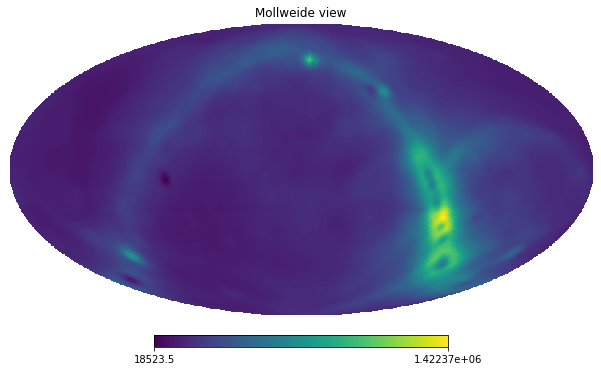

In [17]:
healpy.mollview(sim.sky.hp_map(nside=64)[10])